# Notebook Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Constant

In [19]:
VOCABULARY_LIMIT = 2500

TOKEN_PROBABILTY_SPAM = 'SpamData/Testing/probability_spam.txt'
TOKEN_PROBABILTY_NONSPAM = 'SpamData/Testing/probability_nonspam.txt'
TOKEN_PROBABILTY_ALL = 'SpamData/Testing/probability_all.txt'

TEST_FEATURE_MTX = 'SpamData/Testing/test_features.txt'
TEST_TARGET = 'SpamData/Testing/test_target.txt'

### Load Data

In [20]:
x_test = np.loadtxt(TEST_FEATURE_MTX, delimiter=' ')
y_test = np.loadtxt(TEST_TARGET, delimiter=' ')
word_spam_prob = np.loadtxt(TOKEN_PROBABILTY_SPAM, delimiter=' ')
word_nonspam_prob = np.loadtxt(TOKEN_PROBABILTY_NONSPAM, delimiter=' ')
word_all_prob = np.loadtxt(TOKEN_PROBABILTY_ALL, delimiter=' ')

# Start of the final steps

$$P(Spam \, | \, X) = \frac{P(X \, | \, Spam) \, P(Spam)} {P(X)}$$

In [21]:
# Example of working with the dot product using built-in pandas function
print('The shape of the Dot Product is: ', x_test.dot(word_spam_prob).shape)

The shape of the Dot Product is:  (1724,)


In [22]:
word_spam_prob.shape

(2500,)

In [24]:
# Example of setting up a Prior for the probability of spam.
SPAM_PRIOR = 0.3116

np.log(word_spam_prob)

array([ -4.42126722,  -5.26535481,  -5.00036415, ..., -11.4138231 ,
        -9.21659853, -11.008358  ])

### Use log format to calculate Joint Probability

In [27]:
log_spam_joint = x_test.dot(np.log(word_spam_prob) - np.log(word_all_prob)) + np.log(SPAM_PRIOR)

In [28]:
log_spam_joint[:5]

array([22.38910001,  1.97198445, 17.81914969, 18.26950256, 19.57064474])

$$P(NonSpam \, | \, X) = \frac{P(X \, | \, NonSpam) \, (1-P(Spam))} {P(X)}$$

In [29]:
log_nonspam_joint = x_test.dot(np.log(word_nonspam_prob) - np.log(word_all_prob)) + np.log(1-SPAM_PRIOR)

In [30]:
log_nonspam_joint[:5]

array([-58.96708939, -10.8607011 , -34.76042877, -59.05739738,
       -53.10903931])

# Making Predictions by checking for the higher joint probability

$$P(Spam \, | \, X) \, > \, P(NonSpam \, | \, X)$$
<br>
<center><b>OR</b></center>
<br>
$$P(Spam \, | \, X) \, < \, P(NonSpam \, | \, X)$$

In [31]:
email_prediction = log_spam_joint > log_nonspam_joint

### Comparing the first 5 emails in the result of the email prediction against the test data.

In [34]:
email_prediction[:5]*1

array([1, 1, 1, 1, 1])

In [35]:
y_test[:5]

array([1., 1., 1., 1., 1.])

In [41]:
# Log Simplification
log_spam_joint = x_test.dot(np.log(word_spam_prob)) + np.log(SPAM_PRIOR)
log_nonspam_joint = x_test.dot(np.log(word_nonspam_prob)) + np.log(1-SPAM_PRIOR)

# Evaluations and Metrics

## ML model accuracy

In [36]:
# We want to know how many emails the model classified correctly
correct_emails = (y_test == email_prediction).sum()
incorrect_emails = x_test.shape[0] - correct_emails 
print('Emails correctly classified: ', correct_emails)
print('Emails incorrectly classified: ', incorrect_emails)

Emails correctly classified:  1685
Emails incorrectly classified:  39


In [37]:
# Getting the ML Model Accuracy
model_accuracy = correct_emails/len(x_test)
model_inaccuracy = incorrect_emails/len(x_test)
print('The model accuracy is {:.1%}'.format(model_accuracy))
print('The model inaccuracy is {:.1%}'.format(model_inaccuracy))

The model accuracy is 97.7%
The model inaccuracy is 2.3%


## False Positives and False Negatives
### Calculate our true positives, false negatives and false positives.

In [97]:
# How often we predicted non-spam and how many times we predicted spam.
np.unique(email_prediction, return_counts=True)

(array([False,  True]), array([1138,  586], dtype=int64))

In [104]:
# Get the true positives
# Model thinks that an email is spam but it is spam.

true_positive = (y_test == 1) & (email_prediction == 1)
print('True Positives:',true_positive.sum())

True Positives: 568


In [103]:
# Get the false positives
# Model thinks that an email is spam but it is a non-spam.

false_positive = (y_test == 0) & (email_prediction == 1)
print('False Positives:',false_positive.sum())

False Positives: 18


In [102]:
# Get the false positives
# Model thinks that an email is non-spam when it is spam.

false_negative = (y_test == 1) & (email_prediction == 0)
print('False Positives:',false_negative.sum())

False Positives: 21


## Recall or Sensitivity Metric
### Recall score maximum value is 1.

In [108]:
# Recall score = true positive / (true positive + false negative)
# The lower the number of false negatives the better the recall score will be.

recall_score = true_positive.sum()/(true_positive.sum() + false_negative.sum())
print('The Recall score is equal to: {:.2%}'.format(recall_score))

The Recall score is equal to: 96.43%


## Precision Metric

In [110]:
# Precision score = true positive / (true positive + false positives)
# Ration of correctly predicted spams to the total number of times we predicted that
# an email was a spam.

precision_score = true_positive.sum()/(true_positive.sum() + false_positive.sum())
print('The Precision score is equal to: {:.2%}'.format(precision_score))

The Precision score is equal to: 96.93%


## F-Score metric

In [113]:
# F-Score = 2x((precision x recall)/(precision + recall))
# This is way of blending the two previous metrics (Recall and Precision) into one
f_score = 2* (precision_score*recall_score)/(precision_score+recall_score)
print('The F-Score is equal to: {:.2%}'.format(f_score))

The F-Score is equal to: 96.68%


# Exploration and Data Visualization

In [57]:
# Setup the charts #1 (Using matplotlib)
yaxis_label = 'P(X | Spam)'
xaxis_label = 'P(X | NonSpam)'

boudary_line = np.linspace(start=-14000, stop=1, num=1000)

### Create two copies of the scatter plot to better visualize the more dense area.

#### Matplotlib data Visualization

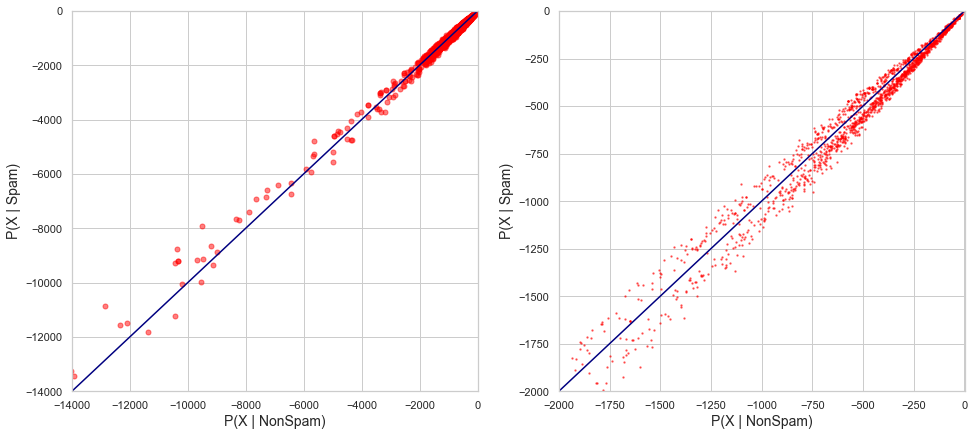

In [64]:
# Display scatter plot and subplot
plt.figure(figsize=(16,7))

# Char #1
plt.subplot(1, 2, 1)

plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# Set Scale
plt.xlim([-14000,1])
plt.ylim([-14000,1])

plt.scatter(log_nonspam_joint, log_spam_joint, color='red', alpha=0.5, s=25)

# Adding a decision boundary for chart #1
plt.plot(boudary_line, boudary_line, color='navy')

# Char #2
plt.subplot(1, 2, 2)

plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# Set Scale
plt.xlim([-2000,1])
plt.ylim([-2000,1])

plt.scatter(log_nonspam_joint, log_spam_joint, color='red', alpha=0.5, s=2)

# Adding a decision boundary for chart #2
plt.plot(boudary_line, boudary_line, color='navy')

plt.show()

#### Seaborn data Visualization

In [65]:
# Setup the charts #2 (Using Seaborn)
sns.set()
sns.set_style('whitegrid')
labels = 'Category'

df_summary = pd.DataFrame({yaxis_label: log_spam_joint, xaxis_label: log_nonspam_joint, 
                          labels: y_test})

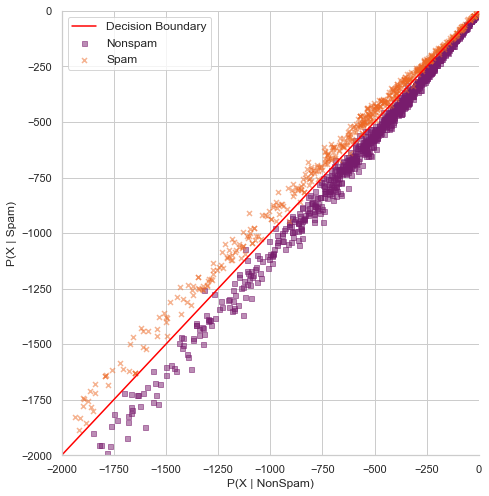

In [93]:
sns.lmplot(x=xaxis_label, y=yaxis_label, data=df_summary, height=7,
          fit_reg=False,scatter_kws={'alpha': 0.5, 's': 25}, hue=labels,
          markers=['s','x'], palette='inferno', legend=False)
# Set Scale
plt.xlim([-2000,1])
plt.ylim([-2000,1])

# Set the decision boundary
plt.plot(boudary_line, boudary_line, color='red')

# Set the legends
plt.legend(('Decision Boundary', 'Nonspam', 'Spam'), fontsize=12)

plt.show()